# Autor: Jorge Cabrejas Peñuelas

## Asignatura: Cloud Computing

### Instalamos paquetes necesarios

In [ ]:
!pip3 install numpy
!pip3 install matplotlib

### Paquetes a importar

In [ ]:
import json

import subprocess as sp
from subprocess import PIPE
from subprocess import STDOUT
import statistics
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

### Importamos una configuración

In [3]:
with open('conf/file.config') as f:
    config_file = json.load(f)

### Funciones auxiliares para trabajar con Docker

In [4]:
def execute_command(command):
    """
    This function is to execute commands

    :param command: command to execute
    :return: None

    """
    result = sp.run(command, stdout=PIPE, stderr=STDOUT, shell=True)

    if config_file['debug_subprocess']:
        print(f'stdout: {result.stdout.decode("utf-8").rstrip()}')
        print(f'stderr: {result.stdout.decode("utf-8").rstrip()}')

def build_image(tag, dockerfile):
    """
    This function is to build an image with tag

    :param tag: tag of the image
    :return: None

    """

    command = 'docker build -t ' + tag + ' -f build/' + dockerfile + ' build/'
    execute_command(command)


def container_up(container, image):
    """
    This function is to set up a container

    :param container: name of the container
    :param image: image of the container
    :return: None

    """

    # The containers initially do not have network to connect
    command = 'docker run -d --name ' + container + ' ' + image
    execute_command(command)
    
def container_up_with_volume(container, image, path_volume):
    """
    This function is to set up a container with volume

    :param container: name of the container
    :param image: image of the container
    :return: None

    """

    # The containers initially do not have network to connect
    command = 'docker run -d --name ' + container + ' -v ' + path_volume + ':/file.txt '+ image
    execute_command(command)


def make_visible_container_as_namespaces(container):
    """
    This function is to add the container visible from host

    :param container: name of the container
    :return: None

    """

    # Creating the folder netns if it does not exist
    command = 'echo ' + config_file['pass'] + ' | sudo -S mkdir -p /var/run/netns'
    execute_command(command)

    command = 'docker inspect ' + container + ' -f {{.State.Pid}}'
    out = sp.check_output(command, shell=True)
    pid = out.decode("utf-8").split('\n')[0]

    command = (
            'echo ' + config_file['pass'] + ' | sudo -S ln -sf /proc/' + str(pid) + '/ns/net /var/run/netns/' +
            container
    )
    execute_command(command)

def exec_something_in_container(container, something):
    
    """
    This function is to execute an script inside the container

    :param container: name of the container
    :param something: command to execute inside the container
    :return: None

    """
    
    command = 'docker exec ' + container + ' ' + something
    result = sp.run(command, stdout=PIPE, stderr=STDOUT, shell=True)
    
    return float(result.stdout.decode("utf-8").rstrip())
    
def stop_containers():
    """
    This function is to stop all containers

    :return:None

    """

    command = 'docker stop $(docker ps -aq)'
    execute_command(command)


def remove_containers():
    """
    This function is to remove all containers

    :return: None

    """

    command = 'docker rm $(docker ps -aq)'
    execute_command(command)

def remove_images():
    """
    This function is to remove all images

    :return: None

    """

    command = 'docker rmi $(docker images -q) --force'
    execute_command(command)

### Definimos variables globales

In [5]:
files = ['1MB', '10MB', '100MB', '1000MB']
Nex = 100
Nintermediatelayers = 100
driver = 'aufs'

### Dockerfile - Sección III-B

In [ ]:
for i in range(len(files)):
    with open('build/Dockerfile_' + files[i], 'w') as f:
        f.write('FROM ubuntu\n')
        f.write('RUN apt-get update && apt-get install -y python3 && truncate -s ' + files[i] + ' file.txt\n')
        f.write('COPY read_write.py /\n')
        f.write('ENTRYPOINT ["tail", "-f", "/dev/null"]')
    f.close()

### Cálculo Sección III-B

In [ ]:
lst_size_wo_volume = []

for i in range(len(files)):
    tmp = []
    build_image('image_' + files[i].lower(), 'Dockerfile_' + files[i])
    for j in range(Nex):        
        container_up('container', 'image_' + files[i].lower())
        make_visible_container_as_namespaces('container')
        result = exec_something_in_container('container', 'python3 read_write.py')
        tmp.append(result)
        stop_containers()
        remove_containers()
    lst_size_wo_volume.append(statistics.median(tmp))
remove_images()
print(lst_size_wo_volume)

In [6]:
lst_size_wo_volume = [0.008532285690307617, 0.023656845092773438, 0.1909106969833374, 1.1446183919906616]

### Representación Sección III-B

No handles with labels found to put in legend.


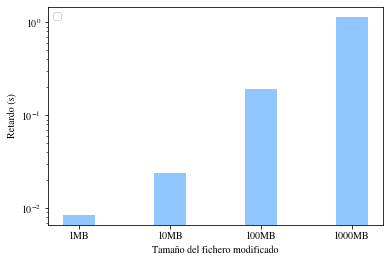

In [7]:
x = np.arange(len(files))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, lst_size_wo_volume, width, color='#92C6FF')
plt.yscale('log')
plt.ylabel('Retardo (s)')
plt.xlabel('Tamaño del fichero modificado')
ax.set_xticks(x)
ax.set_xticklabels(files)
plt.legend(loc="upper left")
plt.savefig('figures/fig1.pdf')

### Dockerfile - Sección III-C

In [ ]:
with open('build/Dockerfile', 'w') as f:
    f.write('FROM ubuntu\n')
    f.write('RUN apt-get update && apt-get -y upgrade && apt-get install -y python3\n')
    f.write('COPY read_write.py /\n')
    f.write('ENTRYPOINT ["tail", "-f", "/dev/null"]')
f.close()

### Cálculo Sección III-C

In [ ]:
lst_size_w_volume = []
build_image('image', 'Dockerfile')
for i in range(len(files)):
    tmp = []
    execute_command('truncate -s ' + files[i] + ' build/file.txt')
    for j in range(Nex):        
        container_up_with_volume('container', 'image', '$(pwd)/build/file.txt')
        make_visible_container_as_namespaces('container')
        result = exec_something_in_container('container', 'python3 read_write.py')
        tmp.append(result)
        stop_containers()
        remove_containers()
    lst_size_w_volume.append(statistics.median(tmp))
remove_images()
print(lst_size_w_volume)

### Resultados Sección III-C

In [8]:
lst_size_w_volume = [0.0005671977996826172, 0.0005748271942138672, 0.0005409717559814453, 0.0005843639373779297]

### Representación Sección III-C

In [9]:
x = np.arange(len(files))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lst_size_wo_volume, width, label='Usando la capa r/w', color='#92C6FF')
rects2 = ax.bar(x + width/2, lst_size_w_volume, width, label='Usando un volumen', color='#97F0AA')
plt.yscale('log')
plt.ylabel('Retardo (s)')
plt.xlabel('Tamaño del fichero modificado')
ax.set_xticks(x)
ax.set_xticklabels(files)
plt.legend(loc="upper left")
plt.savefig('figures/fig2.pdf')

### Dockerfile - Sección III-D (fichero en capas superiores)

In [ ]:
for i in range(len(files)):
    with open('build/Dockerfile_' + files[i] + '_layers', 'w') as f:
        f.write('FROM ubuntu\n')
        f.write('RUN apt-get update && apt-get install -y python3 && truncate -s ' + files[i] + ' file.txt\n')
        f.write('COPY read_write.py /\n')
        for j in range(Nintermediatelayers):
            f.write('COPY read_write.py /\n')
        f.write('ENTRYPOINT ["tail", "-f", "/dev/null"]')
    f.close()

### Cálculo Sección III-D (fichero en capas superiores)

In [ ]:
lst_size_wo_volume_layers1 = []

for i in range(len(files)):
    tmp = []
    build_image('image_' + files[i].lower() + '_layers', 'Dockerfile_' + files[i] + '_layers')
    for j in range(Nex):        
        container_up('container', 'image_' + files[i].lower() + '_layers')
        make_visible_container_as_namespaces('container')
        result = exec_something_in_container('container', 'python3 read_write.py')
        tmp.append(result)
        stop_containers()
        remove_containers()
        print(result)
    lst_size_wo_volume_layers1.append(statistics.median(tmp))
remove_images()
print(lst_size_wo_volume_layers1)

### Resultados Sección III-D (fichero en capas superiores)

In [10]:
lst_size_wo_volume_layers1 = [0.008967161178588867, 0.021671652793884277, 0.2519272565841675, 1.1663650274276733]

### Dockerfile - Sección III-D (fichero en capas inferiores)

In [ ]:
for i in range(len(files)):
    with open('build/Dockerfile_' + files[i] + '_layers2', 'w') as f:
        f.write('FROM ubuntu\n')
        f.write('RUN apt-get update && apt-get install -y python3\n')
        f.write('COPY read_write.py /\n')
        for j in range(Nintermediatelayers-1):
            f.write('COPY read_write.py /\n')
        f.write('RUN truncate -s ' + files[i] + ' file.txt\n')
        f.write('ENTRYPOINT ["tail", "-f", "/dev/null"]')
    f.close()

### Cálculo Sección III-D (fichero en capas inferiores)

In [ ]:
lst_size_wo_volume_layers2 = []

for i in range(len(files)):
    tmp = []
    build_image('image_' + files[i].lower() + '_layers2', 'Dockerfile_' + files[i] + '_layers2')
    for j in range(Nex):        
        container_up('container', 'image_' + files[i].lower() + '_layers2')
        make_visible_container_as_namespaces('container')
        result = exec_something_in_container('container', 'python3 read_write.py')
        tmp.append(result)
        stop_containers()
        remove_containers()
    lst_size_wo_volume_layers2.append(statistics.median(tmp))
remove_images()
print(lst_size_wo_volume_layers2)

### Resultados Sección III-D (fichero en capas inferiores)

In [14]:
lst_size_wo_volume_layers2 = [0.008994102478027344, 0.02187204360961914, 0.13860201835632324, 1.1159530878067017]

### Representación Sección III-D

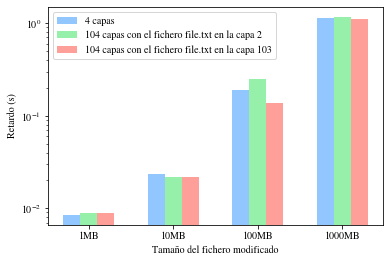

In [15]:
x = np.arange(len(lst_size_wo_volume))  # the label locations
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, lst_size_wo_volume, width, label='4 capas', color='#92C6FF')
rects2 = ax.bar(x, lst_size_wo_volume_layers1, width, label='104 capas con el fichero file.txt en la capa 2', color='#97F0AA')
rects3 = ax.bar(x + width, lst_size_wo_volume_layers2, width, label='104 capas con el fichero file.txt en la capa 103', color='#FF9F9A')
plt.yscale('log')
plt.ylabel('Retardo (s)')
plt.xlabel('Tamaño del fichero modificado')
ax.set_xticks(x)
ax.set_xticklabels(files)
plt.legend(loc="upper left")
plt.savefig('figures/fig3.pdf')

### Cálculo Sección III-E

In [ ]:
lst_size_wo_volume_write = []

for i in range(len(files)):
    tmp = []
    build_image('image_' + files[i].lower(), 'Dockerfile_' + files[i] + '_write')
    for j in range(Nex):        
        container_up('container', 'image_' + files[i].lower())
        make_visible_container_as_namespaces('container')
        result = exec_something_in_container('container', 'python3 write.py')
        tmp.append(result)
        stop_containers()
        remove_containers()
    lst_size_wo_volume_write.append(statistics.median(tmp))
remove_images()
print(lst_size_wo_volume_write)

### Resultados Sección III-E

In [16]:
lst_size_wo_volume_write = [0.000655055046081543, 0.0006576776504516602, 0.0006780624389648438, 0.0006802082061767578]

### Representación Sección III-E

In [17]:
x = np.arange(len(lst_size_wo_volume_write))  # the label locations
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lst_size_wo_volume, width, label='Lectura y escritura', color='#92C6FF')
rects2 = ax.bar(x + width/2, lst_size_wo_volume_write, width, label='Escritura', color='#97F0AA')
plt.yscale('log')
plt.ylabel('Retardo (s)')
plt.xlabel('Tamaño del fichero modificado')
ax.set_xticks(x)
ax.set_xticklabels(files)
plt.legend(loc="upper left")
plt.savefig('figures/fig4.pdf')

### Cálculo Sección III-F

In [ ]:
lst_size_wo_volume = []
lst_size = []
for i in range(len(files)):
    tmp = []
    tmp_size = []
    build_image('image_' + files[i].lower(), 'Dockerfile_' + files[i])
    for j in range(Nex):        
        container_up('container', 'image_' + files[i].lower())
        make_visible_container_as_namespaces('container')
        result = exec_something_in_container('container', 'python3 read_write.py')
        tmp.append(result)
        auxsize = sp.run('echo ' + config_file['pass'] + ' |' + 'sudo -S du -sh -BM /var/lib/docker/' + driver, stdout=PIPE, stderr=STDOUT, shell=True)
        size = int(auxsize.stdout.decode("utf-8").rstrip().split(':')[1].split('M')[0])
        tmp_size.append(size)
        stop_containers()
        remove_containers()
    lst_size_wo_volume.append(statistics.median(tmp))
    lst_size.append(statistics.median(tmp_size))
remove_images()
print(lst_size_wo_volume)
print(lst_size)

### Resultados Sección III-F

In [18]:
lst_size_wo_volume_vfs = [0.0004127025604248047, 0.000408172607421875, 0.0004156827926635742, 0.0004194974899291992]
lst_size_wo_volume_overlay = [0.008899807929992676, 0.029330015182495117, 0.16514909267425537, 1.4104759693145752]
lst_size_wo_volume_overlay2 = [0.008682489395141602, 0.03523457050323486, 0.22511553764343262, 1.6824818849563599]
lst_size_wo_volume_aufs = [0.0013797283172607422, 0.006771206855773926, 0.060425758361816406, 0.574713945388794]

In [19]:
lst_size_wo_volume_size_aufs = [288.0, 363.0, 524.0, 1543.0]
lst_size_wo_volume_size_overlay = [299.0, 396.0, 734.0, 3475.0]
lst_size_wo_volume_size_overlay2 = [290.0, 382.0, 715.0, 3450.0]
lst_size_wo_volume_size_vfs = [809.0, 1130.0, 1778.0, 5687.0]

### Representación Sección III-F

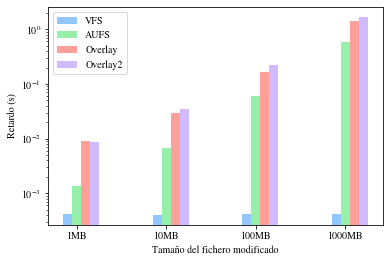

In [20]:
x = np.arange(len(files))
width = 0.1

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, lst_size_wo_volume_vfs, width, label='VFS', color='#92C6FF')
rects2 = ax.bar(x, lst_size_wo_volume_aufs, width, label='AUFS', color='#97F0AA')
rects3 = ax.bar(x + width, lst_size_wo_volume_overlay, width, label='Overlay', color='#FF9F9A')
rects4 = ax.bar(x + 2*width, lst_size_wo_volume_overlay2, width, label='Overlay2', color='#D0BBFF')
plt.yscale('log')
plt.ylabel('Retardo (s)')
plt.xlabel('Tamaño del fichero modificado')
ax.set_xticks(x)
ax.set_xticklabels(files)
plt.legend(loc="upper left")
plt.savefig('figures/fig5.pdf')

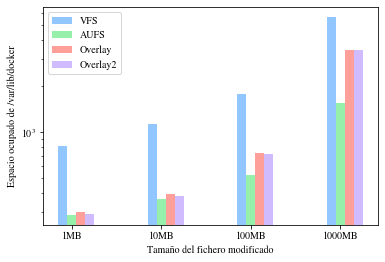

In [21]:
x = np.arange(len(files))
width = 0.1

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, lst_size_wo_volume_size_vfs, width, label='VFS', color='#92C6FF')
rects2 = ax.bar(x, lst_size_wo_volume_size_aufs, width, label='AUFS', color='#97F0AA')
rects3 = ax.bar(x + width, lst_size_wo_volume_size_overlay, width, label='Overlay', color='#FF9F9A')
rects4 = ax.bar(x + 2*width, lst_size_wo_volume_size_overlay2, width, label='Overlay2', color='#D0BBFF')
plt.yscale('log')
plt.ylabel('Espacio ocupado de /var/lib/docker')
plt.xlabel('Tamaño del fichero modificado')
ax.set_xticks(x)
ax.set_xticklabels(files)
plt.legend(loc="upper left")
plt.savefig('figures/fig6.pdf')

### Parar contenedores, borrar contenedores y borrar imágenes

In [22]:
stop_containers()
remove_containers()
remove_images()